In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import binom
import pandas as pd
import math
import pickle
import statsmodels.stats.power
import statsmodels.api as sm
import statsmodels.stats.multitest as mt
from sklearn import datasets

## Power

In [3]:
mu_0 = 30
mu_a = 32
alpha = 0.05
sigma = 4
n = 16
z = stats.norm.ppf(1 - alpha)
print(stats.norm.sf(mu_0 + z * sigma/np.sqrt(n), loc=mu_0, scale=sigma/np.sqrt(n)))
print(stats.norm.sf(mu_0 + z * sigma/np.sqrt(n), loc=mu_a, scale=sigma/np.sqrt(n)))

0.049999999999999954
0.6387600313123348


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Miruna\AppData\Local\Temp\ipykernel_31560\2127023858.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mu_a$')


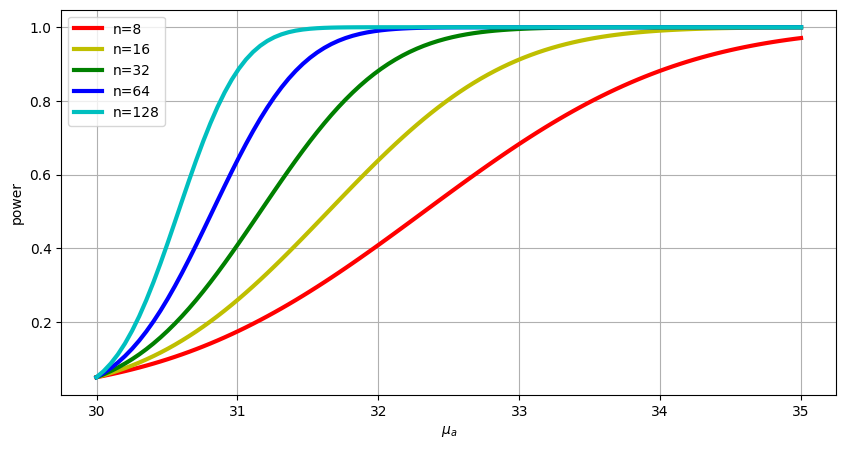

In [4]:
def power(mu_a, n):
    mu_0, alpha, sigma = 30, 0.05, 4
    z = stats.norm.ppf(1 - alpha)
    return stats.norm.sf(mu_0 + z * sigma/np.sqrt(n), loc=mu_a, scale=sigma/np.sqrt(n))

mu_a = np.linspace(30, 35, 100)

plt.figure(figsize=(10,5))
[plt.plot(mu_a, power(mu_a, n), lw=3, color=c) 
     for n,c in [(8, 'r'), (16, 'y'), (32, 'g'), (64, 'b'), (128, 'c')]
]
plt.grid()
plt.legend(['n=8', 'n=16', 'n=32', 'n=64', 'n=128'])
plt.xlabel('$\mu_a$')
plt.ylabel('power')
plt.show()

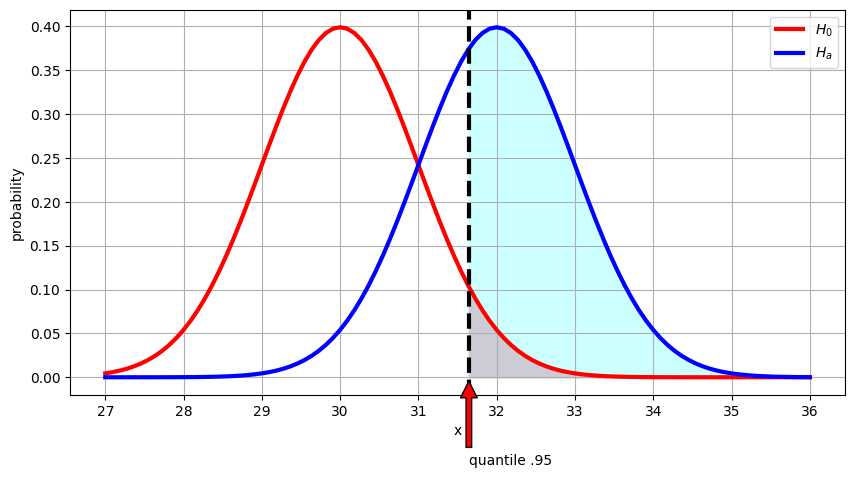

In [5]:
mu_0 = 30
mu_a = 32
sigma = 4
n = 16
alpha = 0.05

x = np.linspace(27, 36, 100)
y_0 = stats.norm.pdf(x, loc=mu_0, scale=sigma/np.sqrt(n))
y_a = stats.norm.pdf(x, loc=mu_a, scale=sigma/np.sqrt(n))
x_black = stats.norm.ppf(0.95, loc=mu_0, scale=sigma/np.sqrt(n))
x1 = np.linspace(x_black, 36, 100)

plt.figure(figsize=(10,5))
plt.plot(x, y_0, lw=3, c='r')
plt.plot(x, y_a, lw=3, c='b')
plt.legend(['$H_0$', '$H_a$'])
plt.grid()
plt.xticks(np.linspace(27, 36, 10))
plt.xlabel('x')
plt.ylabel('probability')
plt.axvline(x=x_black, c='k', linestyle='--', lw=3)
plt.annotate('quantile .95', 
            xy=(x_black, 0), 
            xytext=(x_black, -.1), 
            arrowprops = dict(facecolor='red', shrink=0.05))
plt.fill_between(x1, stats.norm.pdf(x1, loc=mu_0, scale=sigma/np.sqrt(n)), color="pink")
plt.fill_between(x1, stats.norm.pdf(x1, loc=mu_a, scale=sigma/np.sqrt(n)), color="cyan", alpha=0.2)
plt.show()

In [6]:
print(stats.norm.sf(x_black, loc=mu_a, scale=sigma/np.sqrt(n)))
print(statsmodels.stats.power.normal_power(
    effect_size=(mu_a - mu_0)/sigma, 
    nobs=16, alpha=0.05, alternative='larger')
)

0.6387600313123348
0.638760031312335


In [7]:
print('mu_0: %d, mu_a: %d' % (mu_0, mu_a))
print('sigma: ', sigma)
print('power: ', statsmodels.stats.power.ttest_power(
    effect_size=(mu_a - mu_0)/sigma, 
    nobs=16, alpha=0.05, alternative='larger'))

mu_0: 30, mu_a: 32
sigma:  4
power:  0.6040328683316007


In [8]:
print(statsmodels.stats.power.tt_solve_power(
    effect_size=(mu_a - mu_0)/sigma, 
    alpha=0.05, nobs=16, alternative='larger'))
print(statsmodels.stats.power.tt_solve_power(
    effect_size=(mu_a - mu_0)/sigma, 
    alpha=0.05, power=0.6040328, alternative='larger'))

0.6040328683316007
15.99999729935307


# Multiple tests

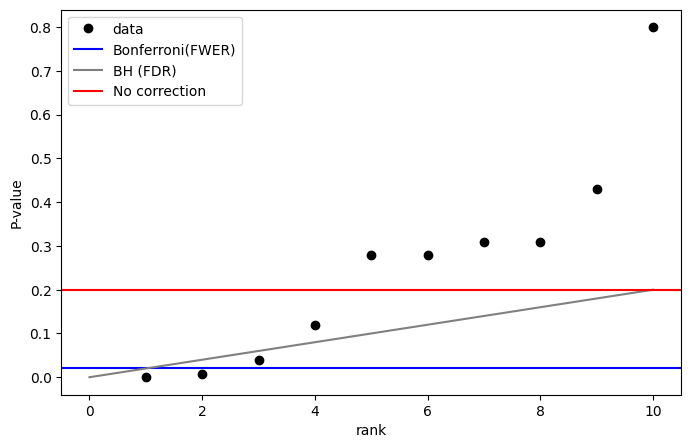

In [9]:
rank = np.array(range(10)) + 1
pValue = np.array([0.001, 0.007, 0.04, 0.12, 0.28, 0.28, 0.31, 0.31, 0.43, 0.8])
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(rank, pValue, 'o', c='k')
ax.axhline(y=0.02, c='b')
ax.plot([0, 10], [0., .2], c='gray')
ax.axhline(y=0.2, c='r')
ax.set_xlabel('rank')
ax.set_ylabel('P-value')
ax.legend(['data', 'Bonferroni(FWER)', 'BH (FDR)', 'No correction'])
plt.show()

In [10]:
n = 1000
pValues = np.zeros(n)
for i in range(n):
    x = np.random.randn(20)
    y = np.random.randn(20)
    x = sm.add_constant(x)
    est = sm.OLS(y, x).fit()
    pValues[i] = est.pvalues[1]
    
print('no correction: ', np.sum(pValues < 0.05))

no correction:  52


In [11]:
res = mt.multipletests(pValues, method='bonferroni')
print('Bonferroni correction: ', np.sum(res[1] < 0.05))

res = mt.multipletests(pValues, method='fdr_bh')
print('Benjamini/Hochberg correction: ', np.sum(res[1] < 0.05))

Bonferroni correction:  0
Benjamini/Hochberg correction:  0


In [12]:
# exemplu pentru care coeficientul w al regresiei liniare este:
# 0 pentru primele 500 de situatii construite
# 2 pentru urmatoarele
n = 1000
pValues = np.zeros(n)
for i in range(n):
    x = np.random.randn(20)
    y = np.random.randn(20) if i < n//2 else (np.random.randn(20) + 2*x)
    x = sm.add_constant(x)
    est = sm.OLS(y, x).fit()
    pValues[i] = est.pvalues[1]
    
print('no correction:', np.sum(pValues < 0.05))
res = mt.multipletests(pValues, method='bonferroni')
print('corectie FWER:' , np.sum(res[1] < 0.05))

no correction: 524
corectie FWER: 480


In [13]:
df = pd.DataFrame({
    'trueStatus': ['zero'] * 500 + ['not zero'] * 500,
    'pValue': pValues
})
pd.crosstab(df.pValue < 0.05, df.trueStatus)

trueStatus,not zero,zero
pValue,,
False,0,476
True,500,24


In [14]:
df = pd.DataFrame({
    'trueStatus': ['zero'] * 500 + ['not zero'] * 500,
    'pValueAdjusted': mt.multipletests(pValues, method='bonferroni')[1]
})
pd.crosstab(df.pValueAdjusted < 0.05, df.trueStatus)

trueStatus,not zero,zero
pValueAdjusted,,
False,20,500
True,480,0


In [15]:
df = pd.DataFrame({
    'trueStatus': ['zero'] * 500 + ['not zero'] * 500,
    'pValueAdjusted': mt.multipletests(pValues, method='fdr_bh')[1]
})
pd.crosstab(df.pValueAdjusted < 0.05, df.trueStatus)

trueStatus,not zero,zero
pValueAdjusted,,
False,0,485
True,500,15


In [16]:
adjustBonf = mt.multipletests(pValues, method='bonferroni')[1]
adjustBH = mt.multipletests(pValues, method='fdr_bh')[1]

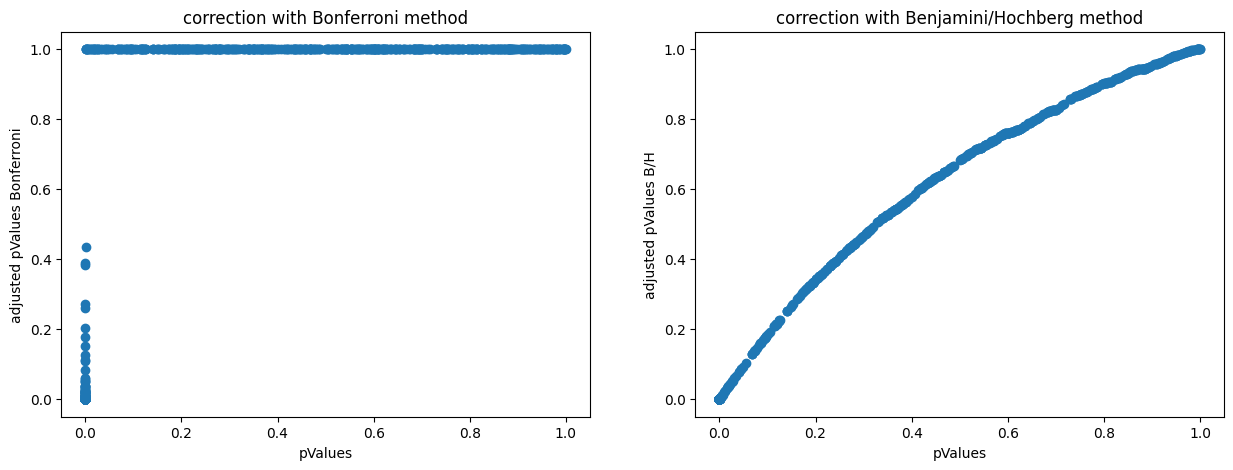

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 5))
ax1.plot(pValues, adjustBonf, 'o')
ax1.set_xlabel('pValues')
ax1.set_ylabel('adjusted pValues Bonferroni')
ax1.set_title('correction with Bonferroni method')
ax2.plot(pValues, adjustBH, 'o')
ax2.set_xlabel('pValues')
ax2.set_ylabel('adjusted pValues B/H')
ax2.set_title('correction with Benjamini/Hochberg method')
plt.show()

## Bootstrap

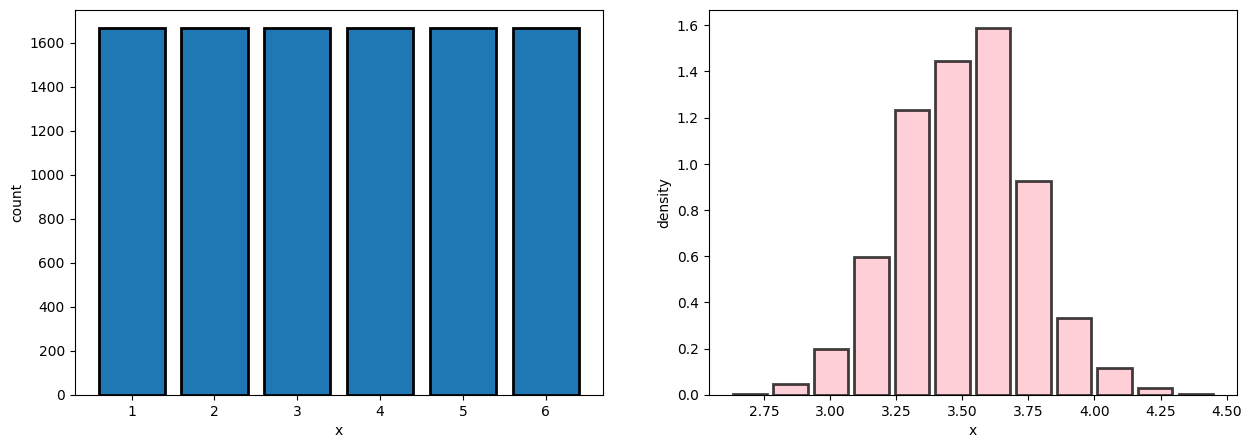

In [18]:
from functools import reduce

def roll(n):
    nosim = 10000
    x = np.random.randint(low=1, high=7, size=(nosim, n))
    return np.mean(x, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
kwargs = dict(rwidth=0.85, density=True, alpha=0.75, ec='k', linewidth=2)

ax1.bar(range(1, 7), [10000/6] * 6, linewidth=2, edgecolor='k')
ax1.set_xlabel('x')
ax1.set_ylabel('count')
ax2.hist(roll(50), bins=12, color='pink', **kwargs)
ax2.set_xlabel('x')
ax2.set_ylabel('density')
plt.show()

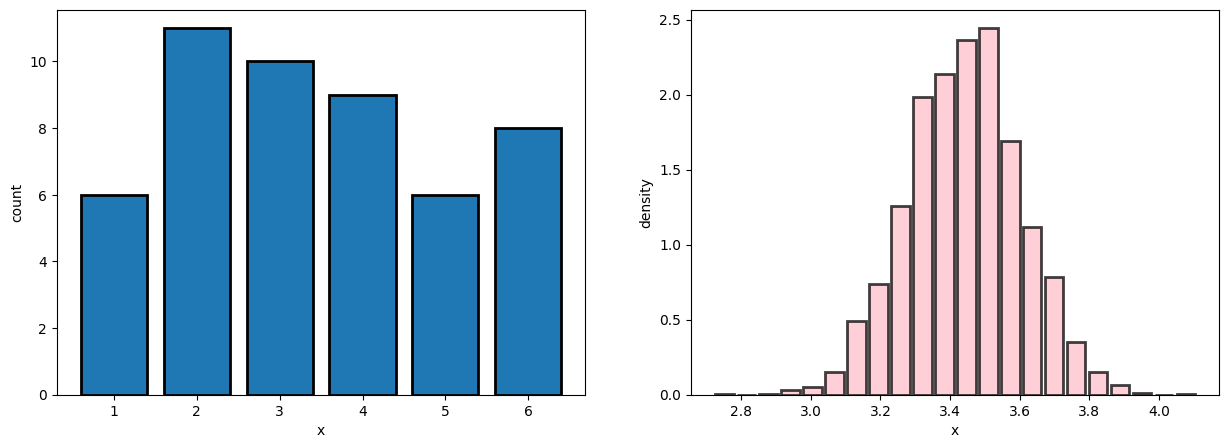

In [19]:
x = np.random.randint(low=1, high=7, size=(50))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
kwargs = dict(rwidth=0.85, density=True, alpha=0.75, ec='k', linewidth=2)

def roll(x, n):
    nosim = 10000
    x = np.random.choice(x, size=(nosim, n))
    return np.mean(x, axis=1)

l = [sum(np.array(x) == i) for i in range(1, 7)]

ax1.bar(range(1, 7), l, linewidth=2, edgecolor='k')
ax1.set_xlabel('x')
ax1.set_ylabel('count')
ax2.hist(roll(x, 100), bins=22, color='pink', **kwargs)
ax2.set_xlabel('x')
ax2.set_ylabel('density')
plt.show()

In [20]:
father_son = pd.read_csv('father_son.csv')
father_son.head()

,Unnamed: 0,fheight,sheight
0,1,65.04851,59.77827
1,2,63.25094,63.21404
2,3,64.95532,63.34242
3,4,65.75250,62.79238
4,5,61.13723,64.28113


C:\Users\Miruna\AppData\Local\Temp\ipykernel_31560\697846580.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(resampledMedians, hist=True, kde=True, bins=60, ax=ax2,


deviatia standard:  0.10437224328984167
quantila 2.5%: 67.54787999999999
quantila 97.5%: 67.94265


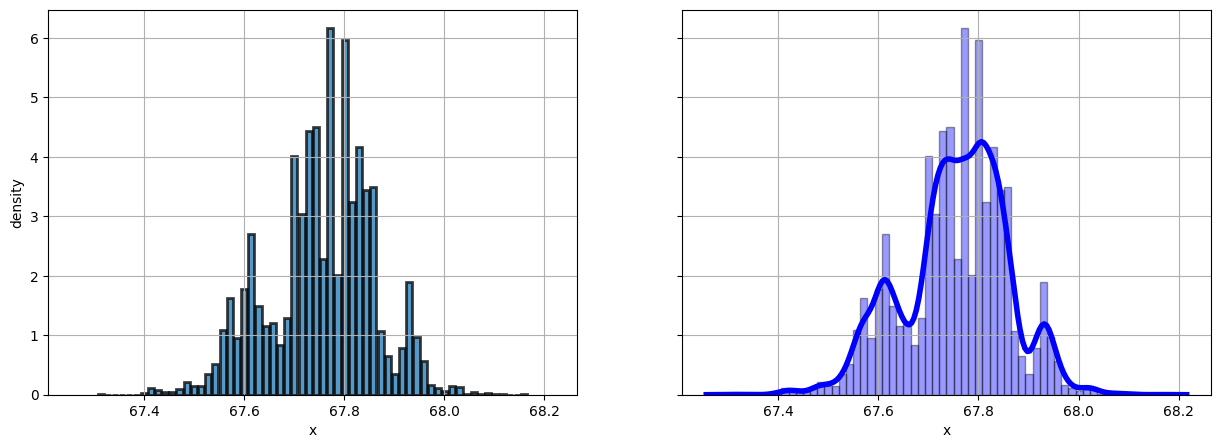

In [21]:
import seaborn

# vezi https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

x = father_son.fheight.values
n, nosims = len(x), 10000
resamples = np.random.choice(x, size=(nosims, n), replace=True)
resampledMedians = np.median(resamples, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
kwargs = dict(rwidth=0.85, density=True, alpha=0.75, ec='k', linewidth=2)
ax1.hist(resampledMedians, **kwargs, bins=60)
ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('density')
seaborn.distplot(resampledMedians, hist=True, kde=True, bins=60, ax=ax2,
    color = 'blue',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
ax2.grid()
ax2.set_xlabel('x')

print('deviatia standard: ', np.std(resampledMedians))
print('quantila 2.5%:', np.quantile(resampledMedians, 0.025))
print('quantila 97.5%:', np.quantile(resampledMedians, 0.975))
plt.show()


In [22]:
insect_sprays = pd.read_csv('insect_sprays.csv')
insect_sprays.head()

,Unnamed: 0,count,spray
0,1,10,A
1,2,7,A
2,3,20,A
3,4,14,A
4,5,14,A


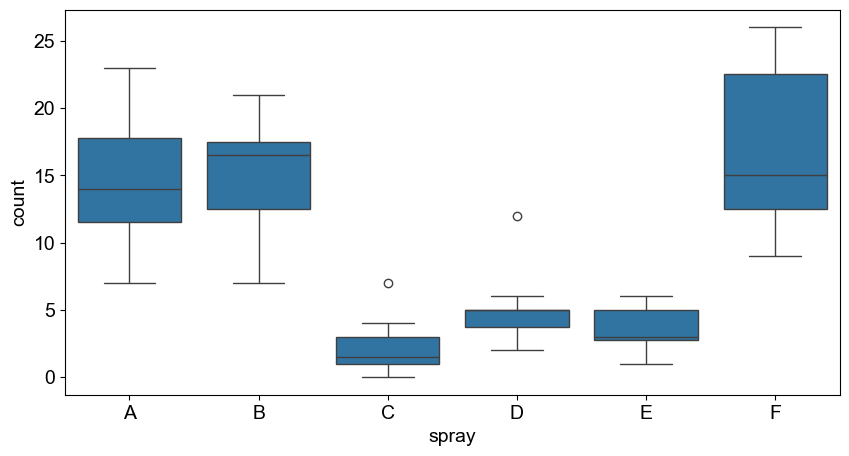

In [23]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
seaborn.set_style('whitegrid')
seaborn.boxplot(x='spray', y='count', data=insect_sprays, ax=ax)
plt.show()

In [24]:
def testStat(a, b, groups):
    return np.mean([y for (x, y) in zip(a, b) if x == groups[0]]) \
        - np.mean([y for (x, y) in zip(a, b) if x == groups[1]])
    
groups = ['B', 'C']
subdata = insect_sprays[insect_sprays.spray.isin(groups)]

observedStat = testStat(subdata['spray'], subdata['count'], groups)

n = subdata['spray'].values.shape[0]
nosims = 10000
permutations = np.array(list(map(
    lambda x: testStat(x, subdata['count'], groups),
    [np.random.choice(subdata['spray'].values, n) for i in range(nosims)]
)))

print(observedStat)
pValue = np.mean(permutations > observedStat)
print(pValue)

13.25
0.0


C:\Users\Miruna\AppData\Local\Temp\ipykernel_31560\1157437873.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(permutations, hist=True, kde=True, bins=80, ax=ax,


deviatia standard:  3.151582268875794
quantila 2.5%: -6.1571428571428575
quantila 97.5%: 6.1571428571428575


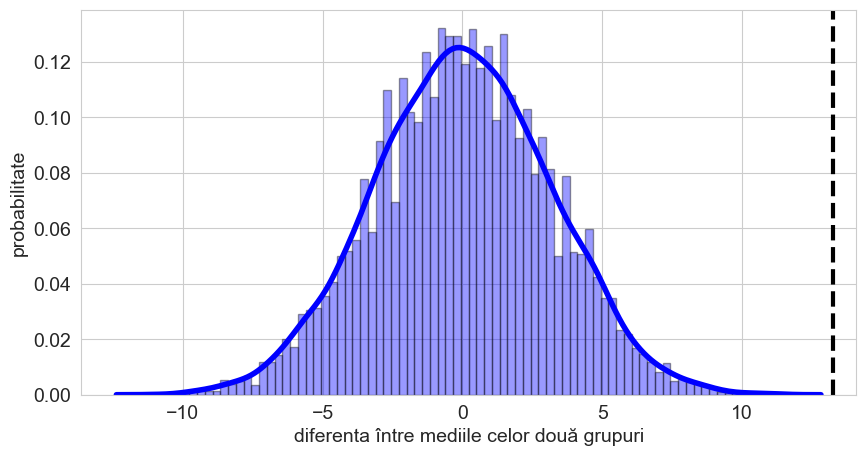

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
seaborn.distplot(permutations, hist=True, kde=True, bins=80, ax=ax,
    color = 'blue',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
ax.grid(True)
ax.set_xlabel('diferenta între mediile celor două grupuri')
ax.set_ylabel('probabilitate')
ax.axvline(x=observedStat, lw=3, c='k', linestyle='--')

print('deviatia standard: ', np.std(permutations))
print('quantila 2.5%:', np.quantile(permutations, 0.025))
print('quantila 97.5%:', np.quantile(permutations, 0.975))
plt.show()

In [26]:
groups = ['D', 'C']
subdata = insect_sprays[insect_sprays.spray.isin(groups)]

observedStat = testStat(subdata['spray'], subdata['count'], groups)

n = subdata['spray'].values.shape[0]
nosims = 10000
permutations = np.array(list(map(
    lambda x: testStat(x, subdata['count'], groups),
    [np.random.choice(subdata['spray'].values, n) for i in range(nosims)]
)))

print(observedStat)
pValue = np.mean(permutations > observedStat)
print(pValue)

2.8333333333333335
0.0015


C:\Users\Miruna\AppData\Local\Temp\ipykernel_31560\1157437873.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(permutations, hist=True, kde=True, bins=80, ax=ax,


deviatia standard:  1.094004251244091
quantila 2.5%: -2.057276785714286
quantila 97.5%: 2.0625


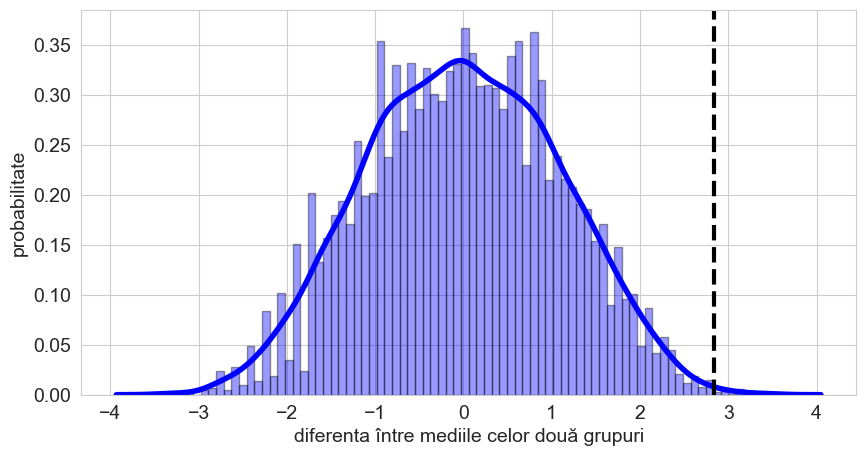

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
seaborn.distplot(permutations, hist=True, kde=True, bins=80, ax=ax,
    color = 'blue',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
ax.grid(True)
ax.set_xlabel('diferenta între mediile celor două grupuri')
ax.set_ylabel('probabilitate')
ax.axvline(x=observedStat, lw=3, c='k', linestyle='--')

print('deviatia standard: ', np.std(permutations))
print('quantila 2.5%:', np.quantile(permutations, 0.025))
print('quantila 97.5%:', np.quantile(permutations, 0.975))
plt.show()

# Laborator

__Q1__. Power este o probabilitate pentru care se presupune că este adevărată:

1. ipoteza nulă $H_0$
2. ipoteza alternativă $H_a$
3. ambele

In [28]:
print("2.ipoteza alternativă  𝐻𝑎")
#Power este probabilitatea de a respinge ipoteza nulă când aceasta este falsă.


2.ipoteza alternativă  𝐻𝑎


__Q2__. Pe măsură ce dimensiunea sample-ului crește, restul menținîndu-se constant, ce se întâmplă cu power?

1. se mărește
2. se micșorează
3. rămâne la fel
4. nu putem preciza

In [29]:
print("1.se mărește")
#Power crește odată cu mărirea dimensiunii sample-ului deoarece crește precizia estimării mediei populației.

1.se mărește


__Q3__. Ce se întâmplă cu power pe măsură ce $\mu_a$ se îndepărtează față de $\mu_0$ ?

In [30]:
#pe măsură ce  𝜇𝑎 se îndepărtează față de  𝜇0, power-ul crește(păstrând toate celelalte constante - dimensiunea sample-ului, deviația standard și nivelul de semnificație),
#deoarece o diferenta mai mare face mai usor ca testul statistic să observe și să confirme că există o diferență reală, 
#reducând astfel șansa de a nu detecta o diferență când, de fapt, una există (reducerea erorilor de tip II).

__Q4__. În contextul calculului power, ce este 'effect size'?

In [31]:
#effect size arată cât de semnificativă este diferența între, de exemplu, două medii grupuri
#(cum ar fi grupul care a primit un tratament versus grupul care a primit un placebo) 

__Q5__. Presupunem că în cazul unei testări A/B, o schemă de publicitate a determinat o medie de 10 achiziții pe zi pentru un sample de 100 de zile, în timp ce pentru cealaltă a determinat o medie de 11 achiziții pe zi, pentru același interval de 100 de zile. Presupunem o deviație standard de 4 achiziții pe zi pentru ambele distribuții. 

Media de 10 achiziții/zi este $\mu_0$ asociată ipotezei nule, iar pentru ipoteza alternativă $\mu_a = 11$. Care ar fi power pentru un test Z one-sided cu confidența de 95% ($\alpha=5\%$), în care presupunem că media achizițiilor a crescut la ipoteza alternativă?

In [32]:
#I
#aplic formula (mu_a - mu_0) / sigma pentru a calcula effect size, nobs este dimensiunea sample-ului, alpha este nivelul de semnificație și alternative este tipul de test.
#larger inseamna ca se testeaza daca mu_a > mu_0 pentru un test one-sided
print('power:', statsmodels.stats.power.normal_power(effect_size= (11 - 10) / 4 , nobs=100, alpha=0.05, alternative='larger')) 

#II
#ppf setează un prag sub care ne așteptăm să cadă o anumită proporție a datelor presupunând că ipoteza nulă este adevărată.
#După stabilirea valorii critice cu ppf, funcția sf este utilizată pentru a evalua cât de probabil este 
#ca rezultatele observate sub ipoteza alternativă să depășească această valoare. 
x_black = stats.norm.ppf(0.95, loc=10, scale=4/10) 
print('power calculat direct:', stats.norm.sf(x_black, loc=11, scale=4/10))

#deci daca power e 0,8, atunci probabilitatea de a face o eroare de tip II este de 0,2, adica probabilitatea de a nu respinge ipoteza nulă când aceasta este falsă

power: 0.8037649400154937
power calculat direct: 0.8037649400154938


__Q6__. Se dorește crearea unui studiu pentru detectarea valorii medii pe 4 ani a pierderii de volum a creierului de 0.01 $mm^3$. Presupunem că deviația standard pe media acestor 4 ani este de 0.04 $mm^3$. Care este numărul de voluntari pe care trebuie să se facă studiul pentru un test 5% vs. ipoteza nulă că nu se pierde deloc volum, pentru a atinge power de 80% ?

In [33]:
from statsmodels.stats.power import tt_solve_power


#5% este nivelul de semnificație, adica de a respinge ipoteza nulă când aceasta este adevărată(eroare de tip I)
mean_difference = 0.01 #diferenta intre medii
sd = 0.04 
effect_size = mean_difference / sd

#tt_solve_power calculeaza dimensiunea sample-ului necesar pentru a atinge un anumit power, adica probabilitatea de a respinge ipoteza nulă când aceasta este falsă
nobs = tt_solve_power(effect_size, alpha=0.05, power=0.8, alternative='larger')
print('Numărul de voluntari necesar:', int(nobs))

Numărul de voluntari necesar: 100


__Q7__. Un studiu a observat asocierea mai multor factor nutriționali cu cancerul mamar (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4166692/). Au fost calculate următoarele p-values:

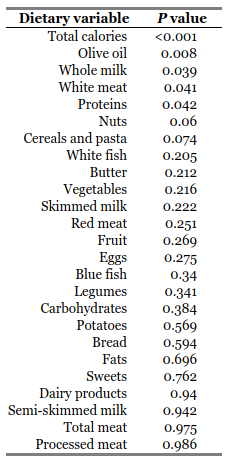

Considerăm un test cu 95% confidență.

a) Fără corecție, care factori sunt relevanți statistic ?

b) Aplicați corecția Bonferroni pe aceste p-values. Care din factori este statistic semnificativ.

c) Aplicați corecția Benjamini/Hochberg. Care factori sunt relevanți statistic?

Reprezentați grafic p-values cu corecția Bonferroni vs. p-values fără corecție, respectiv p-values cu corecția Benjamini/Hochberg vs. p-values fără corecție. Puneți pe ambele grafice și pragul de 0.05 ca să vedem ce rejectăm și ce nu.

In [34]:
# a) fara corectie
factors = pd.DataFrame({'variable': ['total calories', 'olive oil', 'whole meat', 'white meat', 'proteins', 
    'nuts', 'cereals and pasta', 'white fish', 'butter', 'vegetables', 'skimmed milk', 'red meat', 'fruit', 
    'eggs', 'blue fish', 'legumes', 'carbohydrates', 'potatoes', 'bread', 'fats', 'sweets', 'dairy', 
    'semi-skimmed', 'total meat', 'processed meat'], 
    'pvalue': [0.001, 0.008, 0.039, 0.041, 0.042, 0.06, 0.074, 0.205, 0.212, 0.216, 0.222, 0.251, 0.269, 0.275,
               0.34, 0.341, 0.384, 0.569, 0.594, 0.696, 0.752, 0.94, 0.942, 0.975, 0.986]})

pValues = factors['pvalue'].values

#your code here
relevant_factors = factors[factors['pvalue'] < 0.05] #factorii relevanti sunt cei cu pvalue < 0.05
print(relevant_factors)

         variable  pvalue
0  total calories   0.001
1       olive oil   0.008
2      whole meat   0.039
3      white meat   0.041
4        proteins   0.042


In [35]:
# b) corectia Bonferroni
bonferroni_threshold = 0.05 / 24  #noul prag de semnificație ajustat

# corecția Bonferroni verificând care valori p sunt mai mici decât pragul ajustat
relevant_factors_bonferroni = factors[factors['pvalue'] < bonferroni_threshold]

print('Bonferroni threshold:', bonferroni_threshold)
print('Relevant factors after Bonferroni correction:')
print(relevant_factors_bonferroni)


Bonferroni threshold: 0.0020833333333333333
Relevant factors after Bonferroni correction:
         variable  pvalue
0  total calories   0.001


In [36]:
# c) corectia Benjamini/Hochberg
from statsmodels.stats.multitest import multipletests

#multipletests returneaza o serie de valori, dar ne intereseaza doar rejected si pvals_corrected,
# deoarece rejected contine un vector de valori booleane care indica daca ipoteza nula a fost respinsa sau nu, iar pvals_corrected contine p-values corectate
rejected, pvals_corrected, _, _ = multipletests(pValues, alpha=0.05, method='fdr_bh') 

#factorii semnificativi sunt cei pentru care ipoteza nula a fost respinsa
significant_factors = factors[rejected]['variable'].values

print('Benjamini/Hochberg correction: ', significant_factors)

Benjamini/Hochberg correction:  ['total calories']


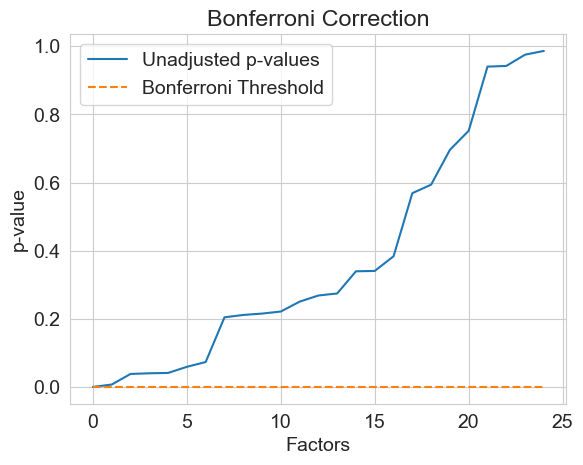

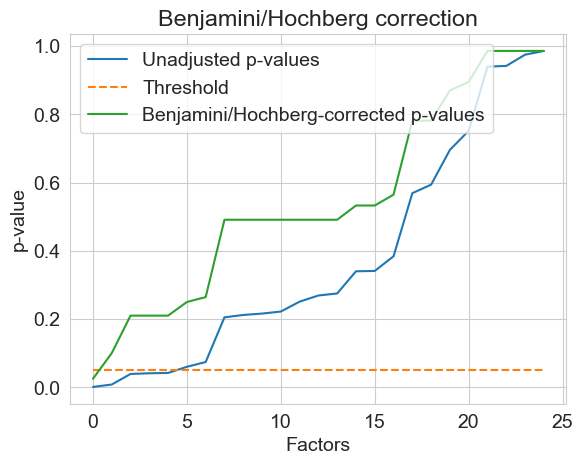

In [37]:
# %matplotlib notebook

# your compared graphs here

# Corecția Bonferroni
bonferroni_threshold = 0.05 / len(pValues)
p_values_bonf= pValues < bonferroni_threshold


# Corecția Benjamini/Hochberg
rejected, pvals_corrected, _, _ = multipletests(pValues, alpha=0.05, method='fdr_bh')

# graficul pentru corecția Bonferroni
fig, ax = plt.subplots()
ax.plot(range(len(pValues)), pValues, label='Unadjusted p-values')
ax.plot(range(len(pValues)), [bonferroni_threshold] * len(pValues), linestyle='--', label='Bonferroni Threshold')
ax.set_xlabel('Factors')
ax.set_ylabel('p-value')
ax.set_title('Bonferroni Correction')
ax.legend()
plt.show()


# graficul pentru corecția Benjamini/Hochberg
fig, ax = plt.subplots()
ax.plot(range(len(pValues)), pValues, label='Unadjusted p-values')
ax.plot(range(len(pValues)), [alpha] * len(pValues), linestyle='--', label='Threshold')
ax.plot(range(len(pValues)), pvals_corrected, label='Benjamini/Hochberg-corrected p-values')
ax.set_xlabel('Factors')
ax.set_ylabel('p-value')
ax.set_title('Benjamini/Hochberg correction')
ax.legend()
plt.show()

__Q8__. Ce folosește procedura bootstrap pentru a estima distribuția sampled a unei statistici ?

In [38]:
#Procedura bootstrap folosește resampling-ul din datele existente pentru a estima distribuția unei statistici, 
#permițând calculul erorilor standard și a intervalelor de încredere.
#Aceasta este utilă atunci când nu se cunoaște distribuția unei statistici sau când se dorește o estimare robustă a erorilor standard.
#eroarea standard spune cât de mult poți aștepta să varieze estimarea dintr-un sample la altul și este folosită pentru a calcula intervale de încredere și p-values

__Q9__. Ce fac testele de resampling? Care este ipoteza nulă și care este ipoteza alternativă? Care este p-value?

In [39]:
#Testele de resampling, cum ar fi bootstrap/permutare, sunt folosite pentru a evalua ipoteze statistice fără a depinde de
# presupuneri stricte legate de distribuția datelor. Ele creează multiple versiuni ale datelor prin resampling sau rearanjare pentru a evalua probabilitatea unei ipoteze.

#Ipoteza nulă (H_0) este ipoteza de bază care susține că nu există efect sau diferență între grupuri sau variabile testate.
#Ipoteza alternativă (H_1) este ipoteza care susține contrariul ipotezei nule, adică există un efect sau o diferență.

#P-value este probabilitatea de a observa rezultatele obținute sau ceva mai extreme, dacă ipoteza nulă este adevărată.
# Un p-value mic (de obicei mai mic decât pragul de 0.05) sugerează că este improbabil să obții aceste rezultate dacă ipoteza nulă este adevărată, 
#conducând la respingerea ipotezei nule.


__Q10__. Realizați două grupuri de numere eșantionate din două distribuții, de medii 10 și respectiv 15, și dispersie 2. Etichetați fiecare sample cu numele grupului, A sau B. Grupurile au dimensiunile 40 și respectiv 50.

Ridicați whiskers plots pentru ambele grupuri.

a) Realizați testul de permutare pentru a arăta dacă numerele sunt sau nu extrase din aceeași distribuție. Stabiliți care este ipoteza nulă și care este ipoteza alternativă. Afișați distribuția mediei resample-urilor. Ce p-value obțineți pentru statistica de tip medie? Care este rezultatul testului ipotezei?

b) Creșteți dispersia grupurilor de la 2 la 100 și reluați experimentul. Ce constatați?

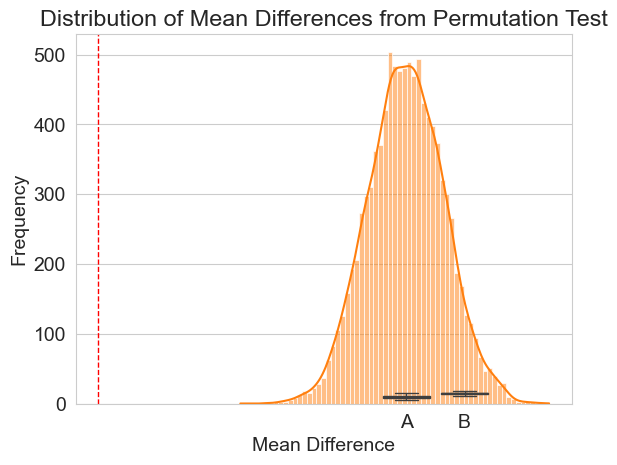

In [41]:
from scipy.stats import ttest_ind

np.random.seed(123)  

group_a = np.random.normal(loc=10, scale=np.sqrt(2), size=40) 
group_b = np.random.normal(loc=15, scale=np.sqrt(2), size=50)


dist1 = np.random.normal(loc=10, scale=2, size=40) 
dist2 = np.random.normal(loc=15, scale=2, size=50)

groups = np.concatenate([np.repeat('A', 40), np.repeat('B', 50)])

data = pd.DataFrame({'value': np.concatenate([dist1, dist2]), 'group': groups})

seaborn.boxplot(x='group', y='value', data=data)

#Ipoteze pentru Testul de Permutare
#------------------------------------
# - ipoteza nulă (H_0): nu există nicio diferență între mediile grupurilor A și B
# - ipoteza alternativă (H_1): există o diferență semnificativă între mediile grupurilor A și B


#Rezultatele Testului de Permutare 
# * cu dispersia inițială
#-------------------------------------------------------
# - p-value: 4.39606829458331e-21 => diferențele dintre medii sunt semnificative statistic
# t_stat, p_value = ttest_ind(dist1, dist2)
# # Output the p-value
# print("P-value:", p_value)


# * cu dispersia crescută la 100
#-------------------------------------------------------
# - am crescut dispersia la 100 și am repetat experimentul, obținând un p-value de 0.7795670550903754
# t_stat, p_value = ttest_ind(dist1, dist2)
# # Output the p-value
# print("P-value:", p_value)
# - acest rezultat arată că, cu o dispersie mai mare, nu am putut identifica diferențe semnificative între grupuri, 
#   sugerând că variabilitatea ridicată poate masca efectele reale


n_permutations = 10000
perm_diffs = []
observed_diff = np.mean(group_a) - np.mean(group_b)  # diferenta observata intre medii pentru grupurile A si B originale 

values = np.concatenate([group_a, group_b])  
groups = np.array(['A']*40 + ['B']*50) 

for _ in range(n_permutations):
    np.random.shuffle(groups)
    perm_group_a = values[groups == 'A']
    perm_group_b = values[groups == 'B']
    perm_diff = np.mean(perm_group_a) - np.mean(perm_group_b)
    perm_diffs.append(perm_diff)

seaborn.histplot(perm_diffs, kde=True)
plt.axvline(x=observed_diff, color='red', linestyle='dashed', linewidth=1)
plt.title('Distribution of Mean Differences from Permutation Test')
plt.xlabel('Mean Difference')
plt.ylabel('Frequency')
plt.show()

